In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import matplotlib.image as mpimg
import time
import gc

In [2]:

# improve the ploting style
rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = 22
rcParams['mathtext.fontset'] = 'stix'

torch.Size([50000, 10]) torch.Size([10000, 10])


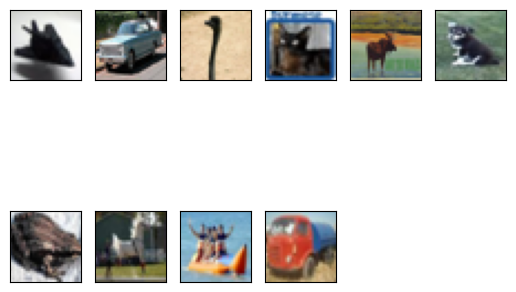

torch.Size([10000, 32, 32, 3]) torch.Size([10000, 1]) tensor([[1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.]]) torch.Size([2000, 32, 32, 3]) torch.Size([2000, 1])


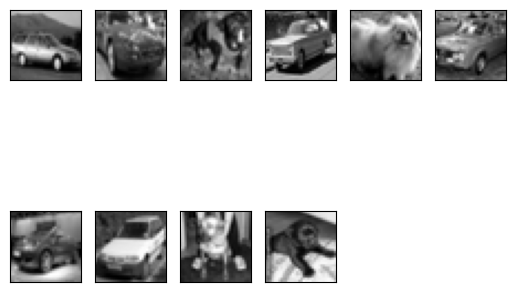

torch.Size([10000, 1024]) torch.Size([2000, 1024])


In [3]:
dtype = torch.float32

transform_data = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) # Apply the (x - mean)/var operation on the components of the data # if x is in [0,1] then Normalise(x) is in [-1,1] # is applied on the three channels RGB
])

# Data import
dtype = torch.float32
trainset = torchvision.datasets.CIFAR10(root = './datas', train= True, download = True, transform = transform_data)
validset = torchvision.datasets.CIFAR10(root = './datas', train = False, download = True, transform = transform_data)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 1)

x_train, y_train_raw, x_valid, y_valid_raw = torch.tensor(trainset.data), torch.tensor(trainset.targets), torch.tensor(validset.data), torch.tensor(validset.targets)

# Modification du format des données shape (n_data,1) -> (n_data, n_classes)
y_train = torch.zeros((y_train_raw.shape[0], torch.max(y_train_raw)+1))
for i, y in enumerate(y_train_raw):
    j = int(y.item())
    y_train[i,j] = 1

y_valid = torch.zeros((y_valid_raw.shape[0], torch.max(y_valid_raw)+1))
for i,y in enumerate(y_valid_raw):
    j = int(y.item())
    y_valid[i,j] = 1 
print(y_train.shape, y_valid.shape)

# Binary reduction of the classes # To avoid using softmax, we regroup classes in two classes
class_binary_reduction = True
determination_des_classes = True
black_and_white_images = True

if class_binary_reduction :
    if determination_des_classes :
        # Determination des classes
        class_list = []
        class_index = 0
        for i in range (x_train.shape[0]):
            if y_train[i, class_index] == 1:
                class_list.append(x_train[i])
                class_index += 1
            if len(class_list) == len(y_train[0]):
                break
        for i, image in enumerate(class_list):
            plt.subplot(2, int(len(class_list)/2+1),i+1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
        plt.show()
                
    # classe1 = [0, 1, 8, 9]  # vehicles
    # classe2 = [2, 3, 4, 5]  # animals
    
    # classe1 = [1, 3, 4]  # elk, truck, dog
    # classe2 = [5, 7, 9]  # horse, car, cat

    classe1 = [1]  # elk
    classe2 = [5]  # horse
    
    # Création des masques pour les échantillons appartenant à ces classes
    mask_classe1_train = y_train[:, classe1].sum(dim=1) > 0  # True si appartient à classe1
    mask_classe2_train = y_train[:, classe2].sum(dim=1) > 0  # True si appartient à classe2
    
    mask_classe1_valid = y_valid[:, classe1].sum(dim=1) > 0
    mask_classe2_valid = y_valid[:, classe2].sum(dim=1) > 0
    
    # Filtrage des exemples concernés
    mask_train = torch.logical_or(mask_classe1_train, mask_classe2_train)
    mask_valid = torch.logical_or(mask_classe1_valid, mask_classe2_valid)
    x_train, y_train = x_train[mask_train], y_train[mask_train]
    x_valid, y_valid = x_valid[mask_valid], y_valid[mask_valid]

    # Création du vecteur de labels binaires (1 pour classe1, 0 pour classe2)
    y_train = (y_train[:, classe1].sum(dim=1) > 0).to(dtype).unsqueeze(1)
    y_valid = (y_valid[:, classe1].sum(dim=1) > 0).to(dtype).unsqueeze(1)
    
    # Avec tanh
    
    # x_train = 2*(x_train-0.5)
    # y_train = 2*(y_train-0.5)
    # x_valid = 2*(x_valid-0.5)
    # y_valid = 2*(y_valid-0.5)

    print(x_train.shape, y_train.shape, y_train[0:10], x_valid.shape, y_valid.shape)

if black_and_white_images :
    x_train = 0.299*x_train[:,:,:,0] + 0.587*x_train[:,:,:,1] + 0.114*x_train[:,:,:,2]
    x_valid = 0.299*x_valid[:,:,:,0] + 0.587*x_valid[:,:,:,1] + 0.114*x_valid[:,:,:,2]
    for i, image in enumerate(x_train[0:10]):
        plt.subplot(2, int(len(x_train[0:10])/2+1),i+1)
        plt.imshow(image, cmap = 'grey')
        plt.xticks([])
        plt.yticks([])
    plt.show()
    x_train, x_valid = (x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])).to(dtype), x_valid.reshape(x_valid.shape[0], x_valid.shape[1]*x_valid.shape[2]).to(dtype)
    print(x_train.shape, x_valid.shape)

else :    
    x_train, x_valid = (x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]*x_train.shape[3])).to(dtype), x_valid.reshape(x_valid.shape[0], x_valid.shape[1]*x_valid.shape[2]*x_valid.shape[3]).to(dtype)
    print(x_train.shape, x_valid.shape)

In [ ]:
dtype = torch.float32

if torch.backends.mps.is_available():
    device = torch.device("mps")
else :
    device = torch.device("cpu")
print("Computing on : ", device)

def ReLU(x):
    return torch.max(torch.tensor(0).to(device),x)

def ReLU_derivative(x):
    return (x>0).type(dtype).to(device)

def softmax_derivative(s):
    """
    s : Tensor de shape (n_batch, num_classes), déjà softmaxé
    Renvoie : Tensor de shape (n_batch, num_classes, num_classes) contenant la jacobienne de softmax pour chaque échantillon
    """
    s = s.to(device)
    n, C = s.shape
    jacobians = torch.zeros(n, C, C, dtype=s.dtype).to(device) # Initialisation du tenseur Jacobien (n_batch, num_classes, num_classes) => (i,j,k) = dérivée de softmax au logit j du ième batch par rapport au logit k du même batch
    for i in range(n):  # Pour chaque échantillon du batch, on calcule la jacobienne de softmax
        si = s[i].unsqueeze(1)  # shape (C, 1) # vecteur softmax(logits) pour la i-ème donnée du batch
        jacobians[i] = torch.diagflat(si) - torch.mm(si,si.t()) # calcul de la jacobienne (matrice des dérivées croisées) de softmax au point z_i = vect(logits_i) # shape (C, C) -> Indice du Jacobien : lignes, Indice des logits : colonnes
    return jacobians

def sigmoid(x):
    return 1/(1+torch.exp(-x))

def sigmoid_derivative(x):
    return torch.exp(-x)/((1 + torch.exp(-x))**2)

def tanh_derivative(x):
    return (1 - (torch.tanh(x)**2)).to(device)

class two_layer_NN(nn.Module):
    def __init__(self,input_dimension,hidden_1_size,number_of_classes,lr=1e-3, reg1 = 0, reg2 = 0, eps_init=1, fraction_batch=0.01, observation_rate = 100):
        """
        Constructor of the two-layer neural network class.
        """
        super(two_layer_NN,self).__init__()
        self.architecture = ""
        self.input_dimension = input_dimension
        self.hidden_1_size = hidden_1_size
        self.number_of_classes = number_of_classes
        self.lr = lr
        self.eps_init = eps_init
        self.reg1 = reg1
        self.reg2 = reg2
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        self.training_time = 0
        # Initializing layers and bias        
        self.W1 = torch.randn(hidden_1_size, input_dimension, dtype=dtype) / np.sqrt(input_dimension) # will lead to a sum over "input_dimension" coefficients, thus to normalise the norm, we divide by "input_dimension"
        self.W2 = self.eps_init*torch.randn(number_of_classes, hidden_1_size, dtype=dtype ) / np.sqrt(hidden_1_size)
        self.b1 = (2*torch.rand(hidden_1_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-1,1)
        self.b2 = eps_init*(2*torch.rand(number_of_classes,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-eps,eps) # on mutiplie par eps pour que les biais soient petits et ainsi éviter l'explosion ou le vanishing des gradients
        # Moving to device 
        self.W1 = self.W1.to(device)
        self.W2 = self.W2.to(device)
        self.b1 = self.b1.to(device)
        self.b2 = self.b2.to(device)
        # Initializing Softmax
        self.softmax = nn.Softmax(dim=1) # on applique la fonction softmax sur la dimension 1 (c'est à dire sur les classes) # dim=0 correspond à la dimension des batchs
        #Initializing losses and accuracies during training list
        self.validation_loss_trajectory = []
        self.training_loss_trajectory = []
        self.accuracy_trajectory = []
        # Activation = ReLU
        # Loss = 0.5*MSE
        # Optimizer = GD
        
    def forward(self, x):
        z1 = (torch.mm(self.W1, x.t()) + self.b1).t() # shape (n_data, hidden_1_size) # logits layer 1
        h1 = ReLU(z1)  # hidden neurons layer 1
        z2 = (torch.mm(self.W2, h1.t()) + self.b2).t() # shape (n_data, number_of_classes ) # logits layer 2
        output = self.softmax(z2) # output layer # shape (n_data, number_of_classes)
        return output, z2, h1, z1
    
    # coef_iter est a ajusté en fonction du seuil kappa_eff d'apprentissage des données.
    def train_layers(self, x_train, y_train, x_valid, y_valid, kappa = 2, lr=1e-3, reg1=0, reg2=0, eps_init=1, fraction_batch=0.01, observation_rate = 100, train_layer_1 = True, train_layer_2 = True):
        # Initializing the training chronometer
        start = time.time()
        unwanted_time = 0
        # Initializing training parameters
        self.architecture = "2 layers" + " - Training first layer : " + str(train_layer_1) + " - Training second layer : " + str(train_layer_2) + " - kappa = " + str(kappa) + " - lr = " + str(lr) + " - reg1 = " + str(reg1) + " - reg2 = " + str(reg2) + " - eps_init = " + str(eps_init) + " - fraction_batch = " + str(fraction_batch) 
        self.lr = lr
        self.reg1 = reg1
        self.reg2 = reg2
        self.eps_init = eps_init
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        # Initializing the number of training iterations 
        N_datas = self.input_dimension**(kappa)/self.fraction_batch # Number of datas that we want to use for the training
        minibatch_size = int(x_train.shape[0]*self.fraction_batch)
        N_iterations = int(N_datas/minibatch_size)
        print(f"For kappa = {kappa}, the number of datas used for the training is {N_datas} and the number of iterations is {N_iterations}.")
        # Moving training and validation datas to device
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_valid = x_valid.to(device)
        y_valid = y_valid.to(device)
        
        for i in range(N_iterations):
            # Sélection un lot de données aléatoires parmis les données d'entrainement 
            indices_minibatch = torch.randperm(x_train.shape[0])[:minibatch_size]
            x_minibatch, y_minibatch = x_train[indices_minibatch], y_train[indices_minibatch] 
            # Calcul de la prédiction
            output, z2, h1, z1 = self.forward(x_minibatch)
            
            # Suivi de l'apprentissage # l'échantillonnage dépend d'observation_rate
            if i % self.observation_rate == 0:    
                unwanted_time_begin = time.time() # Pour soustraire le temps lié à la sauvegarde des données d'apprentissage au temps d'entrainement
                # Calcul des losses et de l'accuracy et ajout aux trajectoires
                training_loss = torch.mean(0.5*(output - y_minibatch)**2) # shape (number_of_classes, 1) # on divise par le nombre d'échantillons du minibatch pour obtenir la moyenne empirique de la loss
                validation_loss = torch.mean(0.5*(self.forward(x_valid)[0] - y_valid)**2)
                self.training_loss_trajectory.append(training_loss.item())
                self.validation_loss_trajectory.append(validation_loss.item())
                accuracy = torch.mean((torch.argmax(self.forward(x_valid)[0], dim=1) == torch.argmax(y_valid, dim=1)).to(dtype))
                self.accuracy_trajectory.append(accuracy.item())
                print("Iteration", i, "Training loss", training_loss.item(), "Validation loss", validation_loss.item(), "Accuracy", accuracy.item())
                # Soustraction du temps de sauvegarde
                unwanted_time += time.time() - unwanted_time_begin 
                
            # Loss = 0.5*(output - y_batch)**2 + reg1*||W1||**2 + reg1*||b1||**2 + reg2*||W2||**2 + reg2*||b2||**2 # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1)
            
            # Calcul des gradients
            grad_output = output - y_minibatch; grad_output = grad_output.to(dtype)
            grad_z2 = torch.einsum('noz, no->nz', softmax_derivative(output), grad_output); grad_z2  = grad_z2.to(dtype) # shape(n_data, num_classes) # produit du gradient de la loss par rapport aux outputs shape(n_data, num_classes) et du tenseur des Jacobiennes des outputs (n_data, num_classes, num_classes) # On multiplie la dimension des outputs (=dL/dy_i) du gradient avec la dimensions des outputs de la jacobienne (=dy_i/dz_j) pour obtenir le grad_z2 (dL(y_i)/dy_i)*(dy_i/dz_j)
            grad_h1 = torch.mm(grad_z2, self.W2); grad_h1  = grad_h1.to(dtype)  # shape (n_data, hidden_1_size)
            grad_z1 = grad_h1*ReLU_derivative(z1); grad_z1  = grad_z1.to(dtype) # shape (n_data, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/dW1 par backpropagation
            grad_W1 = (torch.mm(grad_z1.t(), x_minibatch)/x_minibatch.shape[0]).to(dtype) # shape (hidden_1_size, input_dimension)
            # Calcul de la moyenne empirique de dLoss/db1 par backpropagation
            grad_b1 = (torch.mean(grad_z1, dim=0).unsqueeze(1)).to(dtype) 
            # Calcul de la moyenne empirique de dLoss/dW2 par backpropagation
            grad_W2 = (torch.mm(grad_z2.t(), h1)/x_minibatch.shape[0]).to(dtype) # shape (number_of_classes, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/db2 par backpropagation
            grad_b2 = (torch.mean(grad_z2, dim=0).unsqueeze(1)).to(dtype)
            
            # Mise à jours des paramètres de la première couche
            if train_layer_1:
                self.W1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_W1/(self.eps_init**2) + self.reg1*self.W1)).to(dtype) # on multiplie par (hidden_1_size)**2 pour compenser la dilution du gradient avec l'augmentation de la taille de la couche de neurone (correction de la variance) # on divise par eps^2 pour compenser la faible amplitude des couches suivantes (Réajustement d'échelle) # on pénalise l'augmentation de la norme des poids de W1
                self.b1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_b1/(self.eps_init**2) + self.reg1*self.b1)).to(dtype)
            if train_layer_2:
                self.W2 -= (self.lr*(torch.sqrt(torch.tensor(self.number_of_classes))*grad_W2/(self.eps_init**2) +self.reg2*self.W2)).to(dtype)
                self.b2 -= (self.lr*(torch.sqrt(torch.tensor(self.number_of_classes))*grad_b2/(self.eps_init**2) + self.reg2*self.b2)).to(dtype)
            del x_minibatch, y_minibatch, output, z2, h1, z1, grad_output, grad_z2, grad_h1, grad_z1, grad_W1, grad_b1, grad_W2, grad_b2
            gc.collect()
        
        # Calcul de la durée de l'entraînement    
        self.training_time = time.time() - start - unwanted_time
        return "Training done"
   
class three_layer_NN(nn.Module):
    def __init__(self, input_dimension, hidden_1_size, hidden_2_size, number_of_classes,lr=0.01, reg1 =0, reg2 = 0, eps_init=1, fraction_batch=0.01, observation_rate = 10):
        """
        Constructor of the three-layer neural network class.
        """
        super(three_layer_NN,self).__init__()
        # Initialisation des propriétés du réseau
        self.architecture = ""
        self.input_dimension = input_dimension
        self.hidden_1_size = hidden_1_size
        self.hidden_2_size = hidden_2_size
        self.number_of_classes = number_of_classes
        self.lr = lr
        self.eps_init = eps_init
        self.reg1 = reg1
        self.reg2 = reg2
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        
        # Initialisation de la propriété durée d'entrainement
        self.training_time = 0
        
        # Initialisation des couches et des biais du réseau
        self.W1 = torch.randn(hidden_1_size, input_dimension, dtype=dtype) / np.sqrt(input_dimension) # will lead to a sum over "input_dimension" coefficients, thus to normalise the norm, we divide by "input_dimension"
        self.W2 = eps_init*torch.randn(hidden_2_size, hidden_1_size, dtype=dtype ) / np.sqrt(hidden_1_size)
        self.W3 = eps_init*torch.randn(number_of_classes, hidden_2_size, dtype=dtype)/np.sqrt(hidden_2_size)
        self.b1 = (2*torch.rand(hidden_1_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-1,1)
        self.b2 = eps_init*(2*torch.rand(hidden_2_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-eps,eps) # on mutiplie par eps pour que les biais soient petits et ainsi éviter l'explosion ou le vanishing des gradients
        self.b3 = eps_init*(2*torch.rand(number_of_classes,1,dtype=dtype)-1)
        
        # Moving to device 
        self.W1 = self.W1.to(device)
        self.W2 = self.W2.to(device)
        self.W3 = self.W3.to(device)
        self.b1 = self.b1.to(device)
        self.b2 = self.b2.to(device)
        self.b3 = self.b3.to(device)
        
        # Initializing Softmax
        self.softmax = nn.Softmax(dim=1) # on applique la fonction softmax sur la dimension 1 (c'est à dire sur les classes) # dim=0 correspond à la dimension des batchs
        
        #Initializing losses and accuracies during training list
        self.validation_loss_trajectory = []
        self.training_loss_trajectory = []
        self.accuracy_trajectory = []
        # Activation = ReLU
        # Loss = 0.5*MSE
        # Optimizer = GD
        
    def forward(self, x):
        z1 = (torch.mm(self.W1, x.t()) + self.b1).t() # shape (n_data, hidden_1_size) # logits layer 1
        h1 = ReLU(z1)  # hidden neurons layer 1
        z2 = (torch.mm(self.W2, h1.t()) + self.b2).t() # shape (n_data, number_of_classes ) # logits layer 2
        h2 = ReLU(z2) # hidden neurons layer 2
        z3 = (torch.mm(self.W3,h2.t()) + self.b3).t()
        output = self.softmax(z3) # output layer # shape (n_data, number_of_classes)
        return output, z3, h2, z2, h1, z1
    
    def train_layers(self, x_train, y_train, x_valid, y_valid, kappa = 2, lr=1e-3, reg1 = 0, reg2 = 0, reg3 = 0, eps_init=1, fraction_batch=0.01, observation_rate = 10, train_layer_1 = True, train_layer_2 = True, train_layer_3 = True):
        # Initializing training chronometer
        start = time.time()
        unwanted_time = 0
        # Initializing training parameters
        self.architecture = "3 layers" + " - Training first layer : " + str(train_layer_1) + " - Training second layer : " + str(train_layer_2) + " - Training third layer : " + str(train_layer_3) + " - kappa = " + str(kappa) + " - lr = " + str(lr) + " - reg1 = " + str(reg1) + " - reg2 = " + str(reg2) + " - eps_init = " + str(eps_init) + " - fraction_batch = " + str(fraction_batch)
        self.lr = lr
        self.reg1 = reg1
        self.reg2 = reg2
        self.reg3 = reg3
        self.eps_init = eps_init
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        # Moving input datas to device
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_valid = x_valid.to(device)
        y_valid = y_valid.to(device)        
        # Initializing the number of training iterations 
        N_datas = self.input_dimension**(kappa)/self.fraction_batch # Number of datas that we want to use for the training
        minibatch_size = int(x_train.shape[0]*self.fraction_batch)
        N_iterations = int(N_datas/minibatch_size)
        print(f"For kappa = {kappa}, the number of datas used for the training is {N_datas} and the number of iterations is {N_iterations}.")
        
        for i in range(N_iterations):
            
            # Tirage aléatoire d'un minibatch
            indices_minibatch = torch.randperm(x_train.shape[0])[:minibatch_size]
            x_minibatch, y_minibatch = x_train[indices_minibatch], y_train[indices_minibatch] # sélection un lot de données aléatoires parmis les données d'entrainement 
            
            # Calcul de la prédiction
            output, z3, h2, z2, h1, z1 = self.forward(x_minibatch)
            
            # Suivi de l'apprentissage # l'échantillonnage dépend d'observation_rate
            if i % self.observation_rate == 0:    
                unwanted_time_begin = time.time() # Pour soustraire le temps lié à la sauvegarde des données d'apprentissage au temps d'entrainement
                # Calcul des losses et de l'accuracy et ajout aux trajectoires
                training_loss = torch.mean(0.5*(output - y_minibatch)**2) # shape (number_of_classes, 1) # on divise par le nombre d'échantillons du minibatch pour obtenir la moyenne empirique de la loss
                validation_loss = torch.mean(0.5*(self.forward(x_valid)[0] - y_valid)**2)
                self.training_loss_trajectory.append(training_loss.item())
                self.validation_loss_trajectory.append(validation_loss.item())
                accuracy = torch.mean((torch.argmax(self.forward(x_valid)[0], dim=1) == torch.argmax(y_valid, dim=1)).to(dtype))
                self.accuracy_trajectory.append(accuracy.item())
                print("Iteration", i, "Training loss", training_loss.item(), "Validation loss", validation_loss.item(), "Accuracy", accuracy.item())
                # Soustraction du temps de sauvegarde
                unwanted_time += time.time() - unwanted_time_begin 
            
            # Loss = 0.5*(output - y_batch)**2 + reg1*||W1||**2 + reg1*||b1||**2 + reg2*||W2||**2 + reg2*||b2||**2 + reg3*(||W3||**2 + ||b3||**2) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1)
            
            # Calcul des gradients
            grad_output = (output - y_minibatch).to(dtype)
            grad_z3 = (torch.einsum('no,noz->nz',grad_output,softmax_derivative(output))).to(dtype) # shape (n_data, num_classes) # produit du gradient de la loss par rapport aux outputs shape(n_data, num_classes) et du tenseur des Jacobiennes des outputs (n_data, num_classes, num_classes) # On multiplie la dimension des outputs (=dL/dy_i) du gradient avec la dimensions des outputs de la jacobienne (=dy_i/dz_j) pour obtenir le grad_z2 (dL(y_i)/dy_i)*(dy_i/dz_j)
            grad_h2 = (torch.mm(grad_z3, self.W3)).to(dtype) # shape (n_data, hidden_2_size)
            grad_z2 = (grad_h2*ReLU_derivative(z2)).to(dtype) # shape(n_data, hidden_2_size)         
            grad_h1 = (torch.mm(grad_z2, self.W2)).to(dtype)  # shape (n_data, hidden_1_size)
            grad_z1 = (grad_h1*ReLU_derivative(z1)).to(dtype) # shape (n_data, hidden_1_size)
            
            # Calcul de la moyenne empirique de dLoss/dW1 par backpropagation
            grad_W1 = (torch.mm(grad_z1.t(), x_minibatch)/x_minibatch.shape[0]).to(dtype) # shape (hidden_1_size, input_dimension)
            # Calcul de la moyenne empirique de dLoss/db1 par backpropagation
            grad_b1 = (torch.mean(grad_z1, dim=0).unsqueeze(1)).to(dtype) 
            # Calcul de la moyenne empirique de dLoss/dW2 par backpropagation
            grad_W2 = (torch.mm(grad_z2.t(), h1)/x_minibatch.shape[0]).to(dtype) # shape (number_of_classes, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/db2 par backpropagation
            grad_b2 = (torch.mean(grad_z2, dim=0).unsqueeze(1)).to(dtype)
            # Calcul de la moyenne empirique de dLoss/dW3 par backpropagation
            grad_W3 = (torch.mm(grad_z3.t(),h2)/x_minibatch.shape[0]).to(dtype)
            # Calcul de la moyenne empirique du gradient dLoss/db" par backpropagation
            grad_b3 = (torch.mean(grad_z3,dim=0).unsqueeze(1)).to(dtype)
            
            # Mise à jours des paramètres de la première couche
            if train_layer_1:
                self.W1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_W1/(self.eps_init**2) + self.reg1*self.W1)).to(dtype) # on multiplie par (hidden_1_size)**2 pour compenser la dilution du gradient avec l'augmentation de la taille de la couche de neurone (correction de la variance) # on divise par eps^2 pour compenser la faible amplitude des couches suivantes (Réajustement d'échelle) # on pénalise l'augmentation de la norme des poids de W1
                self.b1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_b1/(self.eps_init**2) + self.reg1*self.b1)).to(dtype)
            if train_layer_2:
                self.W2 -= (self.lr*(torch.sqrt(torch.tensor(self.number_of_classes))*grad_W2/(self.eps_init**2) +self.reg2*self.W2)).to(dtype)
                self.b2 -= (self.lr*(torch.sqrt(torch.tensor(self.number_of_classes))*grad_b2/(self.eps_init**2) + self.reg2*self.b2)).to(dtype)
            if train_layer_3:
                self.W3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_W3/(eps_init**2) + self.reg3*self.W3)).to(dtype)
                self.b3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_b3/(eps_init**2) + self.reg3*self.b3)).to(dtype)
            del x_minibatch, y_minibatch, output, z3, h2, z2, h1, z1, grad_output, grad_z3, grad_h2, grad_z2, grad_h1, grad_z1, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3
            gc.collect()
        
        # Calcul de la durée d'entrainement
        self.training_time = time.time() - start - unwanted_time
        return "Training done"

class binary_classification_two_layer_NN(nn.Module):
    def __init__(self,input_dimension,hidden_1_size, lr=1e-3, lr_decay_rate = 1e9, reg1 = 0, reg2 = 0, eps_init=1, fraction_batch=0.01, observation_rate = 100):
        """
        Constructor of the two-layer neural network class.
        """
        super(binary_classification_two_layer_NN,self).__init__()
        self.architecture = ""
        self.input_dimension = input_dimension
        self.hidden_1_size = hidden_1_size
        self.lr = lr
        self.lr_decay_rate = lr_decay_rate
        self.eps_init = eps_init
        self.reg1 = reg1
        self.reg2 = reg2
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        self.training_time = 0
        # Initializing layers and bias        
        self.W1 = torch.randn(hidden_1_size, input_dimension, dtype=dtype) / np.sqrt(input_dimension) # will lead to a sum over "input_dimension" coefficients, thus to normalise the norm, we divide by "input_dimension"
        self.W2 = self.eps_init*torch.randn(1, hidden_1_size, dtype=dtype ) / np.sqrt(hidden_1_size)
        self.b1 = (2*torch.rand(hidden_1_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-1,1)
        self.b2 = eps_init*(2*torch.rand(1,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-eps,eps) # on mutiplie par eps pour que les biais soient petits et ainsi éviter l'explosion ou le vanishing des gradients
        # Moving to device 
        self.W1 = self.W1.to(device)
        self.W2 = self.W2.to(device)
        self.b1 = self.b1.to(device)
        self.b2 = self.b2.to(device)
        #Initializing losses and accuracies during training list
        self.validation_loss_trajectory = []
        self.training_loss_trajectory = []
        self.accuracy_trajectory = []
        # Activation = ReLU
        # Loss = 0.5*MSE
        # Optimizer = GD
        
    def forward(self, x, dropout_rate=0):
        if dropout_rate != 0 :    
            dropout_mask_1 = ((torch.rand((x.shape[0], self.hidden_1_size)) > dropout_rate).to(dtype)).to(device)
        else : 
            dropout_mask_1 = 1
        z1 = (torch.mm(self.W1, x.t()) + self.b1).t() # shape (n_data, hidden_1_size) # logits layer 1
        h1 = ReLU(z1)*dropout_mask_1  # hidden neurons layer 1
        z2 = (torch.mm(self.W2, h1.t()) + self.b2).t() # shape (n_data, number_of_classes ) # logits layer 2
        output = torch.sigmoid(z2) # output layer # shape (n_data, number_of_classes)
        return output, z2, h1, z1
    
    
    # coef_iter est a ajusté en fonction du seuil kappa_eff d'apprentissage des données.
    def train_layers(self, x_train, y_train, x_valid, y_valid, kappa = 2, lr=1e-3, lr_decay_rate = 1e9, reg1=0, reg2=0, eps_init=1, fraction_batch=0.01, observation_rate = 100, train_layer_1 = True, train_layer_2 = True, dropout_rate = 0):
        # Initializing the training chronometer
        start = time.time()
        unwanted_time = 0
        # Initializing training parameters
        self.architecture = "2 layers" + " - Training first layer : " + str(train_layer_1) + " - Training second layer : " + str(train_layer_2) + " - kappa = " + str(kappa) + " - lr = " + str(lr) + " - lr_decay_rate = " + str(lr_decay_rate) + " - reg1 = " + str(reg1) + " - reg2 = " + str(reg2) + " - eps_init = " + str(eps_init) + " - fraction_batch = " + str(fraction_batch) + ' - observation rate = ' + str(observation_rate) + ' - Train layer 1 = ' + str(train_layer_1) + ' - Train layer 2 = ' + str(train_layer_2) + ' - Dropout rate = ' + str(dropout_rate)
        self.lr = torch.tensor(lr)
        self.lr_decay_rate = torch.tensor(lr_decay_rate)
        self.reg1 = reg1
        self.reg2 = reg2
        self.eps_init = eps_init
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        # Initializing the number of training iterations 
        N_datas = self.input_dimension**(kappa)/self.fraction_batch # Number of datas that we want to use for the training
        minibatch_size = int(x_train.shape[0]*self.fraction_batch)
        N_iterations = int(N_datas/minibatch_size)
        print(f"For kappa = {kappa}, the number of datas used for the training is {N_datas} and the number of iterations is {N_iterations}.")
        # Moving training and validation datas to device
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_valid = x_valid.to(device)
        y_valid = y_valid.to(device)
        
        for i in range(N_iterations):
            
            # Sélection un lot de données aléatoires parmis les données d'entrainement 
            indices_minibatch = torch.randperm(x_train.shape[0])[:minibatch_size]
            x_minibatch, y_minibatch = x_train[indices_minibatch], y_train[indices_minibatch] 
            
            # Calcul de la prédiction
            output, z2, h1, z1 = self.forward(x_minibatch, dropout_rate)
            
            # Suivi de l'apprentissage # l'échantillonnage dépend d'observation_rate
            if i % self.observation_rate == 0:    
                unwanted_time_begin = time.time() # Pour soustraire le temps lié à la sauvegarde des données d'apprentissage au temps d'entrainement
                # Calcul des losses et de l'accuracy et ajout aux trajectoires
                print("Output", output[20:22])
                training_loss = torch.mean(0.5*(output - y_minibatch)**2)
                validation_loss = torch.mean(0.5*(self.forward(x_valid)[0] - y_valid)**2)
                self.training_loss_trajectory.append(training_loss.item())
                self.validation_loss_trajectory.append(validation_loss.item())
                accuracy = torch.mean(((self.forward(x_valid)[0] > 0.5).to(dtype) == y_valid).to(dtype))
                self.accuracy_trajectory.append(accuracy.item())
                print("Iteration", i, "Training loss", training_loss.item(), "Validation loss", validation_loss.item(), "Accuracy", accuracy.item())
                # Soustraction du temps de sauvegarde
                unwanted_time += time.time() - unwanted_time_begin 
                
            # Loss = 0.5*(output - y_batch)**2 + reg1*||W1||**2 + reg1*||b1||**2 + reg2*||W2||**2 + reg2*||b2||**2 # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1)
            
            # Calcul des gradients
            grad_output = output - y_minibatch; grad_output = grad_output.to(dtype)
            grad_z2 = grad_output*sigmoid_derivative(z2); grad_z2  = grad_z2.to(dtype) # shape(n_data, 1)
            grad_h1 = torch.mm(grad_z2, self.W2); grad_h1  = grad_h1.to(dtype)  # shape (n_data, hidden_1_size)
            grad_z1 = grad_h1*ReLU_derivative(z1); grad_z1  = grad_z1.to(dtype) # shape (n_data, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/dW1 par backpropagation
            grad_W1 = (torch.mm(grad_z1.t(), x_minibatch)/x_minibatch.shape[0]).to(dtype) # shape (hidden_1_size, input_dimension)
            # Calcul de la moyenne empirique de dLoss/db1 par backpropagation
            grad_b1 = (torch.mean(grad_z1, dim=0).unsqueeze(1)).to(dtype) 
            # Calcul de la moyenne empirique de dLoss/dW2 par backpropagation
            grad_W2 = (torch.mm(grad_z2.t(), h1)/x_minibatch.shape[0]).to(dtype) # shape (number_of_classes, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/db2 par backpropagation
            grad_b2 = (torch.mean(grad_z2, dim=0).unsqueeze(1)).to(dtype)
            
            # if i == 250:
            #     break

            # Mise à jours des paramètres de la première couche
            if train_layer_1:
                self.W1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_W1/(self.eps_init**2) + self.reg1*self.W1)).to(dtype) # on multiplie par (hidden_1_size)**2 pour compenser la dilution du gradient avec l'augmentation de la taille de la couche de neurone (correction de la variance) # on divise par eps^2 pour compenser la faible amplitude des couches suivantes (Réajustement d'échelle) # on pénalise l'augmentation de la norme des poids de W1
                self.b1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_b1/(self.eps_init**2) + self.reg1*self.b1)).to(dtype)
            if train_layer_2:
                self.W2 -= (self.lr*(grad_W2/(self.eps_init**2) +self.reg2*self.W2)).to(dtype)
                self.b2 -= (self.lr*(grad_b2/(self.eps_init**2) + self.reg2*self.b2)).to(dtype)
            del x_minibatch, y_minibatch, output, z2, h1, z1, grad_output, grad_z2, grad_h1, grad_z1, grad_W1, grad_b1, grad_W2, grad_b2
            gc.collect()
            
            # Learning rate decay
            self.lr = lr*torch.exp(torch.tensor(-i/self.lr_decay_rate))
        
        # Calcul de la durée de l'entraînement    
        self.training_time = time.time() - start - unwanted_time
        return "Training done"
    
class binary_classification_three_layer_NN(nn.Module):
    def __init__(self, input_dimension, hidden_1_size, hidden_2_size, lr=0.01, lr_decay_rate = 1e9, reg1 =0, reg2 = 0, eps_init=1, fraction_batch=0.01, observation_rate = 10, dropout_rate = 0):
        """
        Constructor of the three-layer neural network class.
        """
        super(binary_classification_three_layer_NN,self).__init__()
        # Initialisation des propriétés du réseau
        self.architecture = ""
        self.input_dimension = input_dimension
        self.hidden_1_size = hidden_1_size
        self.hidden_2_size = hidden_2_size
        self.lr = lr
        self.lr_decay_rate = lr_decay_rate
        self.eps_init = eps_init
        self.reg1 = reg1
        self.reg2 = reg2
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        
        # Initialisation de la propriété durée d'entrainement
        self.training_time = 0
        
        # Initialisation des couches et des biais du réseau
        self.W1 = torch.randn(hidden_1_size, input_dimension, dtype=dtype) / np.sqrt(input_dimension) # will lead to a sum over "input_dimension" coefficients, thus to normalise the norm, we divide by "input_dimension"
        self.W2 = eps_init*torch.randn(hidden_2_size, hidden_1_size, dtype=dtype ) / np.sqrt(hidden_1_size)
        self.W3 = eps_init*torch.randn(1, hidden_2_size, dtype=dtype)/np.sqrt(hidden_2_size)
        self.b1 = (2*torch.rand(hidden_1_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-1,1)
        self.b2 = eps_init*(2*torch.rand(hidden_2_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-eps,eps) # on mutiplie par eps pour que les biais soient petits et ainsi éviter l'explosion ou le vanishing des gradients
        self.b3 = eps_init*(2*torch.rand(1,1,dtype=dtype)-1)
        
        # Moving to device 
        self.W1 = self.W1.to(device)
        self.W2 = self.W2.to(device)
        self.W3 = self.W3.to(device)
        self.b1 = self.b1.to(device)
        self.b2 = self.b2.to(device)
        self.b3 = self.b3.to(device)
        
        # Initializing Softmax
        self.softmax = nn.Softmax(dim=1) # on applique la fonction softmax sur la dimension 1 (c'est à dire sur les classes) # dim=0 correspond à la dimension des batchs
        
        #Initializing losses and accuracies during training list
        self.validation_loss_trajectory = []
        self.training_loss_trajectory = []
        self.accuracy_trajectory = []
        # Activation = ReLU
        # Loss = 0.5*MSE
        # Optimizer = GD
        
    def forward(self, x, dropout_rate=0):
        if dropout_rate != 0 :    
            dropout_mask_1 = ((torch.rand((x.shape[0], self.hidden_1_size)) > dropout_rate).to(dtype)).to(device)
            dropout_mask_2 = ((torch.rand((x.shape[0], self.hidden_2_size)) > dropout_rate).to(dtype)).to(device)
        else : 
            dropout_mask_1, dropout_mask_2 = 1, 1
        z1 = (torch.mm(self.W1, x.t()) + self.b1).t() # shape (n_data, hidden_1_size) # logits layer 1
        h1 = ReLU(z1)*dropout_mask_1  # hidden neurons layer 1
        z2 = (torch.mm(self.W2, h1.t()) + self.b2).t() # shape (n_data, hidden_2_size ) # logits layer 2
        h2 = ReLU(z2)*dropout_mask_2 # hidden neurons layer 2
        z3 = (torch.mm(self.W3,h2.t()) + self.b3).t() # shape (n_data, 1)
        output = sigmoid(z3) # output layer # shape (n_data, 1)
        return output, z3, h2, z2, h1, z1
    
    def train_layers(self, x_train, y_train, x_valid, y_valid, kappa = 2, lr=1e-3, lr_decay_rate = 1e9, reg1 = 0, reg2 = 0, reg3 = 0, eps_init=1, fraction_batch=0.01, observation_rate = 10, train_layer_1 = True, train_layer_2 = True, train_layer_3 = True, dropout_rate = 0):
        # Initializing training chronometer
        start = time.time()
        unwanted_time = 0
        # Initializing training parameters
        self.architecture = "3 layers" + " - Training first layer : " + str(train_layer_1) + " - Training second layer : " + str(train_layer_2) + " - Training third layer : " + str(train_layer_3) + " - kappa = " + str(kappa) + " - lr = " + str(lr) + " - lr_decay_rate " + str(lr_decay_rate) + " - reg1 = " + str(reg1) + " - reg2 = " + str(reg2) + " - eps_init = " + str(eps_init) + " - fraction_batch = " + str(fraction_batch)
        self.lr = torch.tensor(lr)
        self.decay_rate = lr_decay_rate
        self.reg1 = reg1
        self.reg2 = reg2
        self.reg3 = reg3
        self.eps_init = eps_init
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        # Moving input datas to device
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_valid = x_valid.to(device)
        y_valid = y_valid.to(device)        
        # Initializing the number of training iterations 
        N_datas = self.input_dimension**(kappa)/self.fraction_batch # Number of datas that we want to use for the training
        minibatch_size = int(x_train.shape[0]*self.fraction_batch)
        N_iterations = int(N_datas/minibatch_size)
        print(f"For kappa = {kappa}, the number of datas used for the training is {N_datas} and the number of iterations is {N_iterations}.")
        
        for i in range(N_iterations):
            
            # Tirage aléatoire d'un minibatch
            indices_minibatch = torch.randperm(x_train.shape[0])[:minibatch_size]
            x_minibatch, y_minibatch = x_train[indices_minibatch], y_train[indices_minibatch] # sélection un lot de données aléatoires parmis les données d'entrainement 
            
            # Dropout
            # dropout_mask = ((torch.rand((minibatch_size, x_train.shape[1])) > dropout_rate).to(dtype)).to(device)
            # x_minibatch = x_minibatch*dropout_mask
            
            # Calcul de la prédiction
            output, z3, h2, z2, h1, z1 = self.forward(x_minibatch, dropout_rate)
            
            # Suivi de l'apprentissage # l'échantillonnage dépend d'observation_rate
            if i % self.observation_rate == 0:    
                unwanted_time_begin = time.time() # Pour soustraire le temps lié à la sauvegarde des données d'apprentissage au temps d'entrainement
                # Calcul des losses et de l'accuracy et ajout aux trajectoires
                training_loss = torch.mean(0.5*(output - y_minibatch)**2) # shape (number_of_classes, 1) # on divise par le nombre d'échantillons du minibatch pour obtenir la moyenne empirique de la loss
                validation_loss = torch.mean(0.5*(self.forward(x_valid)[0] - y_valid)**2)
                self.training_loss_trajectory.append(training_loss.item())
                self.validation_loss_trajectory.append(validation_loss.item())
                accuracy = torch.mean(((self.forward(x_valid)[0] > 0.5).to(dtype) == y_valid).to(dtype))
                self.accuracy_trajectory.append(accuracy.item())
                print("Iteration", i, "Training loss", training_loss.item(), "Validation loss", validation_loss.item(), "Accuracy", accuracy.item())
                # Soustraction du temps de sauvegarde
                unwanted_time += time.time() - unwanted_time_begin 
            
            # Loss = 0.5*(output - y_batch)**2 + reg1*||W1||**2 + reg1*||b1||**2 + reg2*||W2||**2 + reg2*||b2||**2 + reg3*(||W3||**2 + ||b3||**2) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1)
            
            # Calcul des gradients
            grad_output = (output - y_minibatch).to(dtype)
            grad_z3 = grad_output*sigmoid_derivative(z3).to(dtype) # shape (n_data, 1) # produit du gradient de la loss par rapport aux outputs shape(n_data, num_classes) et du tenseur des Jacobiennes des outputs (n_data, num_classes, num_classes) # On multiplie la dimension des outputs (=dL/dy_i) du gradient avec la dimensions des outputs de la jacobienne (=dy_i/dz_j) pour obtenir le grad_z2 (dL(y_i)/dy_i)*(dy_i/dz_j)
            grad_h2 = (torch.mm(grad_z3, self.W3)).to(dtype) # shape (n_data, hidden_2_size)
            grad_z2 = (grad_h2*ReLU_derivative(z2)).to(dtype) # shape(n_data, hidden_2_size)         
            grad_h1 = (torch.mm(grad_z2, self.W2)).to(dtype)  # shape (n_data, hidden_1_size)
            grad_z1 = (grad_h1*ReLU_derivative(z1)).to(dtype) # shape (n_data, hidden_1_size)
            
            # Calcul de la moyenne empirique de dLoss/dW1 par backpropagation
            grad_W1 = (torch.mm(grad_z1.t(), x_minibatch)/x_minibatch.shape[0]).to(dtype) # shape (hidden_1_size, input_dimension)
            # Calcul de la moyenne empirique de dLoss/db1 par backpropagation
            grad_b1 = (torch.mean(grad_z1, dim=0).unsqueeze(1)).to(dtype) 
            # Calcul de la moyenne empirique de dLoss/dW2 par backpropagation
            grad_W2 = (torch.mm(grad_z2.t(), h1)/x_minibatch.shape[0]).to(dtype) # shape (number_of_classes, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/db2 par backpropagation
            grad_b2 = (torch.mean(grad_z2, dim=0).unsqueeze(1)).to(dtype)
            # Calcul de la moyenne empirique de dLoss/dW3 par backpropagation
            grad_W3 = (torch.mm(grad_z3.t(),h2)/x_minibatch.shape[0]).to(dtype)
            # Calcul de la moyenne empirique du gradient dLoss/db" par backpropagation
            grad_b3 = (torch.mean(grad_z3,dim=0).unsqueeze(1)).to(dtype)
            
            # Mise à jours des paramètres de la première couche
            if train_layer_1:
                self.W1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_W1/(self.eps_init**2) + self.reg1*self.W1)).to(dtype) # on multiplie par (hidden_1_size)**2 pour compenser la dilution du gradient avec l'augmentation de la taille de la couche de neurone (correction de la variance) # on divise par eps^2 pour compenser la faible amplitude des couches suivantes (Réajustement d'échelle) # on pénalise l'augmentation de la norme des poids de W1
                self.b1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_b1/(self.eps_init**2) + self.reg1*self.b1)).to(dtype)
            if train_layer_2:
                self.W2 -= (self.lr*(grad_W2/(self.eps_init**2) +self.reg2*self.W2)).to(dtype)
                self.b2 -= (self.lr*(grad_b2/(self.eps_init**2) + self.reg2*self.b2)).to(dtype)
            if train_layer_3:
                self.W3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_W3/(eps_init**2) + self.reg3*self.W3)).to(dtype)
                self.b3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_b3/(eps_init**2) + self.reg3*self.b3)).to(dtype)
            del x_minibatch, y_minibatch, output, z3, h2, z2, h1, z1, grad_output, grad_z3, grad_h2, grad_z2, grad_h1, grad_z1, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3
            gc.collect()
            
            # Learning rate decay
            self.lr = lr*torch.exp(torch.tensor(-i/self.lr_decay_rate))
            
            # if i == 12000:
            #     break
        
        # Calcul de la durée d'entrainement
        self.training_time = time.time() - start - unwanted_time
        return "Training done" 

class binary_classification_four_layer_NN(nn.Module):
    def __init__(self, input_dimension, hidden_1_size, hidden_2_size, hidden_3_size, lr=0.01, lr_decay_rate = 1e9, reg1 =0, reg2 = 0, reg3=0, eps_init=1, fraction_batch=0.01, observation_rate = 10, dropout_rate = 0):
        """
        Constructor of the four-layer neural network class.
        """
        super(binary_classification_four_layer_NN,self).__init__()
        # Initialisation des propriétés du réseau
        self.architecture = ""
        self.input_dimension = input_dimension
        self.hidden_1_size = hidden_1_size
        self.hidden_2_size = hidden_2_size
        self.hidden_3_size = hidden_3_size
        self.lr = lr
        self.lr_decay_rate = lr_decay_rate
        self.eps_init = eps_init
        self.reg1 = reg1
        self.reg2 = reg2
        self.reg3 = reg3
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        
        # Initialisation de la propriété durée d'entrainement
        self.training_time = 0
        
        # Initialisation des couches et des biais du réseau
        self.W1 = torch.randn(hidden_1_size, input_dimension, dtype=dtype) / np.sqrt(input_dimension) # will lead to a sum over "input_dimension" coefficients, thus to normalise the norm, we divide by "input_dimension"
        self.W2 = eps_init*torch.randn(hidden_2_size, hidden_1_size, dtype=dtype ) / np.sqrt(hidden_1_size)
        self.W3 = eps_init*torch.randn(hidden_3_size, hidden_2_size, dtype=dtype)/np.sqrt(hidden_2_size)
        self.W4 = eps_init*torch.randn(1, hidden_3_size, dtype = dtype) / np.sqrt(hidden_3_size)
        
        self.b1 = (2*torch.rand(hidden_1_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-1,1)
        self.b2 = eps_init*(2*torch.rand(hidden_2_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-eps,eps) # on mutiplie par eps pour que les biais soient petits et ainsi éviter l'explosion ou le vanishing des gradients
        self.b3 = eps_init*(2*torch.rand(hidden_3_size, 1, dtype=dtype)-1)
        self.b4 = eps_init*(2*torch.rand(1, 1, dtype = dtype)-1)
        
        # Moving to device 
        self.W1 = self.W1.to(device)
        self.W2 = self.W2.to(device)
        self.W3 = self.W3.to(device)
        self.W4 = self.W4.to(device)
        self.b1 = self.b1.to(device)
        self.b2 = self.b2.to(device)
        self.b3 = self.b3.to(device)
        self.b4 = self.b4.to(device)
        
        # Initializing Softmax
        self.softmax = nn.Softmax(dim=1) # on applique la fonction softmax sur la dimension 1 (c'est à dire sur les classes) # dim=0 correspond à la dimension des batchs
        
        #Initializing losses and accuracies during training list
        self.validation_loss_trajectory = []
        self.training_loss_trajectory = []
        self.accuracy_trajectory = []
        # Activation = ReLU
        # Loss = 0.5*MSE
        # Optimizer = GD
        
    def forward(self, x, dropout_rate=0):
        if dropout_rate != 0 :    
            dropout_mask_1 = ((torch.rand((x.shape[0], self.hidden_1_size)) > dropout_rate).to(dtype)).to(device)
            dropout_mask_2 = ((torch.rand((x.shape[0], self.hidden_2_size)) > dropout_rate).to(dtype)).to(device)
            dropout_mask_3 = ((torch.rand((x.shape[0], self.hidden_3_size)) > dropout_rate).to(dtype)).to(device)
        else : 
            dropout_mask_1, dropout_mask_2, dropout_mask_3 = 1, 1, 1
        z1 = (torch.mm(self.W1, x.t()) + self.b1).t() # shape (n_data, hidden_1_size) # logits layer 1
        h1 = ReLU(z1)*dropout_mask_1  # hidden neurons layer 1
        z2 = (torch.mm(self.W2, h1.t()) + self.b2).t() # shape (n_data, hidden_2_size ) # logits layer 2
        h2 = ReLU(z2)*dropout_mask_2 # hidden neurons layer 2
        z3 = (torch.mm(self.W3,h2.t()) + self.b3).t() # shape (n_data, hidden_3_size)
        h3 = ReLU(z3)*dropout_mask_3 # hidden neurons layer_3
        z4 = (torch.mm(self.W4, z3.t()) + self.b4).t() # shape (n_data,1)
        output = sigmoid(z4) # output layer # shape (n_data, 1)
        return output, z4, h3, z3, h2, z2, h1, z1
    
    def train_layers(self, x_train, y_train, x_valid, y_valid, kappa = 2, lr=1e-3, lr_decay_rate = 1e9, reg1 = 0, reg2 = 0, reg3 = 0, reg4 =0, eps_init=1, fraction_batch=0.01, observation_rate = 10, train_layer_1 = True, train_layer_2 = True, train_layer_3 = True, train_layer_4 = True, dropout_rate = 0):
        # Initializing training chronometer
        start = time.time()
        unwanted_time = 0
        # Initializing training parameters
        self.architecture = "3 layers" + " - Training first layer : " + str(train_layer_1) + " - Training second layer : " + str(train_layer_2) + " - Training third layer : " + str(train_layer_3) + " - Training fourth layer = " + str(train_layer_4) + " - kappa = " + str(kappa) + " - lr = " + str(lr) + " - lr_decay_rate " + str(lr_decay_rate) + " - reg1 = " + str(reg1) + " - reg2 = " + str(reg2) + " - eps_init = " + str(eps_init) + " - fraction_batch = " + str(fraction_batch) + " - dropout rate = " + str(dropout_rate)
        self.lr = torch.tensor(lr)
        self.decay_rate = lr_decay_rate
        self.reg1 = reg1
        self.reg2 = reg2
        self.reg3 = reg3
        self.reg4 = reg4
        self.eps_init = eps_init
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        # Moving input datas to device
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_valid = x_valid.to(device)
        y_valid = y_valid.to(device)        
        # Initializing the number of training iterations 
        N_datas = self.input_dimension**(kappa)/self.fraction_batch # Number of datas that we want to use for the training
        minibatch_size = int(x_train.shape[0]*self.fraction_batch)
        N_iterations = int(N_datas/minibatch_size)
        print(f"For kappa = {kappa}, the number of datas used for the training is {N_datas} and the number of iterations is {N_iterations}.")
        
        for i in range(N_iterations):
            
            # Tirage aléatoire d'un minibatch
            indices_minibatch = torch.randperm(x_train.shape[0])[:minibatch_size]
            x_minibatch, y_minibatch = x_train[indices_minibatch], y_train[indices_minibatch] # sélection un lot de données aléatoires parmis les données d'entrainement 
            
            # Dropout
            # dropout_mask = ((torch.rand((minibatch_size, x_train.shape[1])) > dropout_rate).to(dtype)).to(device)
            # x_minibatch = x_minibatch*dropout_mask
            
            # Calcul de la prédiction
            output, z4, h3, z3, h2, z2, h1, z1 = self.forward(x_minibatch, dropout_rate)
            
            # Suivi de l'apprentissage # l'échantillonnage dépend d'observation_rate
            if i % self.observation_rate == 0:    
                unwanted_time_begin = time.time() # Pour soustraire le temps lié à la sauvegarde des données d'apprentissage au temps d'entrainement
                # Calcul des losses et de l'accuracy et ajout aux trajectoires
                training_loss = torch.mean(0.5*(output - y_minibatch)**2) # shape (number_of_classes, 1) # on divise par le nombre d'échantillons du minibatch pour obtenir la moyenne empirique de la loss
                validation_loss = torch.mean(0.5*(self.forward(x_valid)[0] - y_valid)**2)
                self.training_loss_trajectory.append(training_loss.item())
                self.validation_loss_trajectory.append(validation_loss.item())
                accuracy = torch.mean(((self.forward(x_valid)[0] > 0.5).to(dtype) == y_valid).to(dtype))
                self.accuracy_trajectory.append(accuracy.item())
                print("Iteration", i, "Training loss", training_loss.item(), "Validation loss", validation_loss.item(), "Accuracy", accuracy.item())
                # Soustraction du temps de sauvegarde
                unwanted_time += time.time() - unwanted_time_begin 
            
            # Loss = 0.5*(output - y_batch)**2 + reg1*||W1||**2 + reg1*||b1||**2 + reg2*||W2||**2 + reg2*||b2||**2 + reg3*(||W3||**2 + ||b3||**2) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1)
            
            # Calcul des gradients
            grad_output = (output - y_minibatch).to(dtype)  # shape (n_data, 1)
            grad_z4 = grad_output*sigmoid_derivative(z4).to(dtype)  # shape (n_data, 1)
            grad_h3 = (torch.mm(grad_z4, self.W4)).to(dtype)  # shape (n_data, hidden_3_size)
            grad_z3 = grad_h3*sigmoid_derivative(z3).to(dtype) # shape (n_data, hidden_3_size) # produit du gradient de la loss par rapport aux outputs shape(n_data, num_classes) et du tenseur des Jacobiennes des outputs (n_data, num_classes, num_classes) # On multiplie la dimension des outputs (=dL/dy_i) du gradient avec la dimensions des outputs de la jacobienne (=dy_i/dz_j) pour obtenir le grad_z2 (dL(y_i)/dy_i)*(dy_i/dz_j)
            grad_h2 = (torch.mm(grad_z3, self.W3)).to(dtype) # shape (n_data, hidden_2_size)
            grad_z2 = (grad_h2*ReLU_derivative(z2)).to(dtype) # shape(n_data, hidden_2_size)         
            grad_h1 = (torch.mm(grad_z2, self.W2)).to(dtype)  # shape (n_data, hidden_1_size)
            grad_z1 = (grad_h1*ReLU_derivative(z1)).to(dtype) # shape (n_data, hidden_1_size)
            
            # Calcul de la moyenne empirique de dLoss/dW1 par backpropagation
            grad_W1 = (torch.mm(grad_z1.t(), x_minibatch)/x_minibatch.shape[0]).to(dtype) # shape (hidden_1_size, input_dimension)
            # Calcul de la moyenne empirique de dLoss/db1 par backpropagation
            grad_b1 = (torch.mean(grad_z1, dim=0).unsqueeze(1)).to(dtype) 
            # Calcul de la moyenne empirique de dLoss/dW2 par backpropagation
            grad_W2 = (torch.mm(grad_z2.t(), h1)/x_minibatch.shape[0]).to(dtype) # shape (number_of_classes, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/db2 par backpropagation
            grad_b2 = (torch.mean(grad_z2, dim=0).unsqueeze(1)).to(dtype)
            # Calcul de la moyenne empirique de dLoss/dW3 par backpropagation
            grad_W3 = (torch.mm(grad_z3.t(),h2)/x_minibatch.shape[0]).to(dtype)
            # Calcul de la moyenne empirique du gradient dLoss/db" par backpropagation
            grad_b3 = (torch.mean(grad_z3,dim=0).unsqueeze(1)).to(dtype)
            
            grad_W4 = (torch.mm(grad_z4.t(),h3)/x_minibatch.shape[0]).to(dtype)
            
            grad_b4 = (torch.mean(grad_z4, dim=0).unsqueeze(1)).to(dtype)
            
            # Mise à jours des paramètres de la première couche
            if train_layer_1:
                self.W1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_W1/(self.eps_init**2) + self.reg1*self.W1)).to(dtype) # on multiplie par (hidden_1_size)**2 pour compenser la dilution du gradient avec l'augmentation de la taille de la couche de neurone (correction de la variance) # on divise par eps^2 pour compenser la faible amplitude des couches suivantes (Réajustement d'échelle) # on pénalise l'augmentation de la norme des poids de W1
                self.b1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_b1/(self.eps_init**2) + self.reg1*self.b1)).to(dtype)
            if train_layer_2:
                self.W2 -= (self.lr*(grad_W2/(self.eps_init**2) +self.reg2*self.W2)).to(dtype)
                self.b2 -= (self.lr*(grad_b2/(self.eps_init**2) + self.reg2*self.b2)).to(dtype)
            if train_layer_3:
                self.W3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_W3/(eps_init**2) + self.reg3*self.W3)).to(dtype)
                self.b3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_b3/(eps_init**2) + self.reg3*self.b3)).to(dtype)
            if train_layer_3:
                self.W3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_W3/(eps_init**2) + self.reg3*self.W3)).to(dtype)
                self.b3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_b3/(eps_init**2) + self.reg3*self.b3)).to(dtype)
            if train_layer_4:
                self.W4 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_3_size))*grad_W4/(eps_init**2) + self.reg4*self.W4)).to(dtype)
                self.b4 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_3_size))*grad_b4/(eps_init**2) + self.reg4*self.b4)).to(dtype)
            del x_minibatch, y_minibatch, output, z4, h3, z3, h2, z2, h1, z1, grad_output, grad_z4, grad_h3, grad_z3, grad_h2, grad_z2, grad_h1, grad_z1, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3, grad_W4, grad_b4
            gc.collect()
            
            # Learning rate decay
            self.lr = lr*torch.exp(torch.tensor(-i/self.lr_decay_rate))
        
        # Calcul de la durée d'entrainement
        self.training_time = time.time() - start - unwanted_time
        return "Training done" 
    
    
class binary_classification_five_layer_NN(nn.Module):
    def __init__(self, input_dimension, hidden_1_size, hidden_2_size, hidden_3_size, hidden_4_size, lr=0.01, lr_decay_rate = 1e9, reg1=0, reg2=0, reg3=0, reg4=0, reg5=0, eps_init=1, fraction_batch=0.01, observation_rate = 10, dropout_rate = 0):
        """
        Constructor of the five-layer neural network class.
        """
        super(binary_classification_five_layer_NN,self).__init__()
        # Initialisation des propriétés du réseau
        self.architecture = ""
        self.input_dimension = input_dimension
        self.hidden_1_size = hidden_1_size
        self.hidden_2_size = hidden_2_size
        self.hidden_3_size = hidden_3_size
        self.hidden_4_size = hidden_4_size
        self.lr = lr
        self.lr_decay_rate = lr_decay_rate
        self.eps_init = eps_init
        self.reg1 = reg1
        self.reg2 = reg2
        self.reg3 = reg3
        self.reg4 = reg4
        self.reg5 = reg5
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        
        # Initialisation de la propriété durée d'entrainement
        self.training_time = 0
        
        # Initialisation des couches et des biais du réseau
        self.W1 = torch.randn(hidden_1_size, input_dimension, dtype=dtype) / np.sqrt(input_dimension) # will lead to a sum over "input_dimension" coefficients, thus to normalise the norm, we divide by "input_dimension"
        self.W2 = eps_init*torch.randn(hidden_2_size, hidden_1_size, dtype=dtype ) / np.sqrt(hidden_1_size)
        self.W3 = eps_init*torch.randn(hidden_3_size, hidden_2_size, dtype=dtype)/np.sqrt(hidden_2_size)
        self.W4 = eps_init*torch.randn(hidden_4_size, hidden_3_size, dtype = dtype) / np.sqrt(hidden_3_size)
        self.W5 = eps_init*torch.randn(1, hidden_4_size, dtype = dtype) / np.sqrt(hidden_4_size)
        
        self.b1 = (2*torch.rand(hidden_1_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-1,1)
        self.b2 = eps_init*(2*torch.rand(hidden_2_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-eps,eps) # on mutiplie par eps pour que les biais soient petits et ainsi éviter l'explosion ou le vanishing des gradients
        self.b3 = eps_init*(2*torch.rand(hidden_3_size, 1, dtype=dtype)-1)
        self.b4 = eps_init*(2*torch.rand(hidden_4_size, 1, dtype = dtype)-1)
        self.b5 = eps_init*(2*torch.rand(1, 1, dtype = dtype)-1)
        
        # Moving to device 
        self.W1 = self.W1.to(device)
        self.W2 = self.W2.to(device)
        self.W3 = self.W3.to(device)
        self.W4 = self.W4.to(device)
        self.W5 = self.W5.to(device)

        self.b1 = self.b1.to(device)
        self.b2 = self.b2.to(device)
        self.b3 = self.b3.to(device)
        self.b4 = self.b4.to(device)
        self.b5 = self.b5.to(device)

        # Initializing Softmax
        self.softmax = nn.Softmax(dim=1) # on applique la fonction softmax sur la dimension 1 (c'est à dire sur les classes) # dim=0 correspond à la dimension des batchs
        
        #Initializing losses and accuracies during training list
        self.validation_loss_trajectory = []
        self.training_loss_trajectory = []
        self.accuracy_trajectory = []
        # Activation = ReLU
        # Loss = 0.5*MSE
        # Optimizer = GD
        
    def forward(self, x, dropout_rate=0):
        if dropout_rate != 0 :    
            dropout_mask_1 = ((torch.rand((x.shape[0], self.hidden_1_size)) > dropout_rate).to(dtype)).to(device)
            dropout_mask_2 = ((torch.rand((x.shape[0], self.hidden_2_size)) > dropout_rate).to(dtype)).to(device)
            dropout_mask_3 = ((torch.rand((x.shape[0], self.hidden_3_size)) > dropout_rate).to(dtype)).to(device)
            dropout_mask_4 = ((torch.rand((x.shape[0], self.hidden_4_size)) > dropout_rate).to(dtype)).to(device)
        else : 
            dropout_mask_1, dropout_mask_2, dropout_mask_3 = 1, 1, 1
        z1 = (torch.mm(self.W1, x.t()) + self.b1).t() # shape (n_data, hidden_1_size) # logits layer 1
        h1 = ReLU(z1)*dropout_mask_1  # hidden neurons layer 1
        z2 = (torch.mm(self.W2, h1.t()) + self.b2).t() # shape (n_data, hidden_2_size ) # logits layer 2
        h2 = ReLU(z2)*dropout_mask_2 # hidden neurons layer 2
        z3 = (torch.mm(self.W3,h2.t()) + self.b3).t() # shape (n_data, hidden_3_size)
        h3 = ReLU(z3)*dropout_mask_3 # hidden neurons layer_3
        z4 = (torch.mm(self.W4, z3.t()) + self.b4).t() # shape (n_data,1)
        h4 = ReLU(z4)*dropout_mask_4
        z5 = torch.mm(self.W5, h4.t() + self.b5).t()
        output = sigmoid(z5) # output layer # shape (n_data, 1)
        return output, z5, h4, z4, h3, z3, h2, z2, h1, z1
    
    def train_layers(self, x_train, y_train, x_valid, y_valid, kappa = 2, lr=1e-3, lr_decay_rate = 1e9, reg1 = 0, reg2 = 0, reg3 = 0, reg4 =0, reg5=0, eps_init=1, fraction_batch=0.01, observation_rate = 10, train_layer_1 = True, train_layer_2 = True, train_layer_3 = True, train_layer_4 = True, train_layer_5=True, dropout_rate = 0):
        # Initializing training chronometer
        start = time.time()
        unwanted_time = 0
        # Initializing training parameters
        self.architecture = "3 layers" + " - Training first layer : " + str(train_layer_1) + " - Training second layer : " + str(train_layer_2) + " - Training third layer : " + str(train_layer_3) + " - Training fourth layer = " + str(train_layer_4) + " - Training fifth layer = " + str(train_layer_5) + " - kappa = " + str(kappa) + " - lr = " + str(lr) + " - lr_decay_rate " + str(lr_decay_rate) + " - reg1 = " + str(reg1) + " - reg2 = " + str(reg2) + " - eps_init = " + str(eps_init) + " - fraction_batch = " + str(fraction_batch) + " - dropout rate = " + str(dropout_rate)
        self.lr = torch.tensor(lr)
        self.decay_rate = lr_decay_rate
        self.reg1 = reg1
        self.reg2 = reg2
        self.reg3 = reg3
        self.reg4 = reg4
        self.reg5 = reg5
        self.eps_init = eps_init
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        # Moving input datas to device
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_valid = x_valid.to(device)
        y_valid = y_valid.to(device)        
        # Initializing the number of training iterations 
        N_datas = self.input_dimension**(kappa)/self.fraction_batch # Number of datas that we want to use for the training
        minibatch_size = int(x_train.shape[0]*self.fraction_batch)
        N_iterations = int(N_datas/minibatch_size)
        print(f"For kappa = {kappa}, the number of datas used for the training is {N_datas} and the number of iterations is {N_iterations}.")
        
        for i in range(N_iterations):
            
            # Tirage aléatoire d'un minibatch
            indices_minibatch = torch.randperm(x_train.shape[0])[:minibatch_size]
            x_minibatch, y_minibatch = x_train[indices_minibatch], y_train[indices_minibatch] # sélection un lot de données aléatoires parmis les données d'entrainement 
            
            # Dropout
            # dropout_mask = ((torch.rand((minibatch_size, x_train.shape[1])) > dropout_rate).to(dtype)).to(device)
            # x_minibatch = x_minibatch*dropout_mask
            
            # Calcul de la prédiction
            output, z5, h4, z4, h3, z3, h2, z2, h1, z1 = self.forward(x_minibatch, dropout_rate)
            
            # Suivi de l'apprentissage # l'échantillonnage dépend d'observation_rate
            if i % self.observation_rate == 0:    
                unwanted_time_begin = time.time() # Pour soustraire le temps lié à la sauvegarde des données d'apprentissage au temps d'entrainement
                # Calcul des losses et de l'accuracy et ajout aux trajectoires
                training_loss = torch.mean(0.5*(output - y_minibatch)**2) # shape (number_of_classes, 1) # on divise par le nombre d'échantillons du minibatch pour obtenir la moyenne empirique de la loss
                validation_loss = torch.mean(0.5*(self.forward(x_valid)[0] - y_valid)**2)
                self.training_loss_trajectory.append(training_loss.item())
                self.validation_loss_trajectory.append(validation_loss.item())
                accuracy = torch.mean(((self.forward(x_valid)[0] > 0.5).to(dtype) == y_valid).to(dtype))
                self.accuracy_trajectory.append(accuracy.item())
                print("Iteration", i, "Training loss", training_loss.item(), "Validation loss", validation_loss.item(), "Accuracy", accuracy.item())
                # Soustraction du temps de sauvegarde
                unwanted_time += time.time() - unwanted_time_begin 
            
            # Loss = 0.5*(output - y_batch)**2 + reg1*||W1||**2 + reg1*||b1||**2 + reg2*||W2||**2 + reg2*||b2||**2 + reg3*(||W3||**2 + ||b3||**2) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1)
            
            # Calcul des gradients
            grad_output = (output - y_minibatch).to(dtype)  # shape (n_data, 1)
            grad_z5 = grad_output*sigmoid_derivative(z5).to(dtype)  # shape (n_data, 1)
            grad_h4 = torch.mm(grad_z5, self.W5)    # shape (n_data, hidden_4_size)
            grad_z4 = grad_h4*ReLU_derivative(z4)   # shape (n_data, hidden_4_size)
            grad_h3 = (torch.mm(grad_z4, self.W4)).to(dtype)  # shape (n_data, hidden_3_size)
            grad_z3 = grad_h3*sigmoid_derivative(z3).to(dtype) # shape (n_data, hidden_3_size) # produit du gradient de la loss par rapport aux outputs shape(n_data, num_classes) et du tenseur des Jacobiennes des outputs (n_data, num_classes, num_classes) # On multiplie la dimension des outputs (=dL/dy_i) du gradient avec la dimensions des outputs de la jacobienne (=dy_i/dz_j) pour obtenir le grad_z2 (dL(y_i)/dy_i)*(dy_i/dz_j)
            grad_h2 = (torch.mm(grad_z3, self.W3)).to(dtype) # shape (n_data, hidden_2_size)
            grad_z2 = (grad_h2*ReLU_derivative(z2)).to(dtype) # shape(n_data, hidden_2_size)         
            grad_h1 = (torch.mm(grad_z2, self.W2)).to(dtype)  # shape (n_data, hidden_1_size)
            grad_z1 = (grad_h1*ReLU_derivative(z1)).to(dtype) # shape (n_data, hidden_1_size)
            
            # Calcul de la moyenne empirique de dLoss/dW1 par backpropagation
            grad_W1 = (torch.mm(grad_z1.t(), x_minibatch)/x_minibatch.shape[0]).to(dtype) # shape (hidden_1_size, input_dimension)
            # Calcul de la moyenne empirique de dLoss/db1 par backpropagation
            grad_b1 = (torch.mean(grad_z1, dim=0).unsqueeze(1)).to(dtype) 
            # Calcul de la moyenne empirique de dLoss/dW2 par backpropagation
            grad_W2 = (torch.mm(grad_z2.t(), h1)/x_minibatch.shape[0]).to(dtype) # shape (number_of_classes, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/db2 par backpropagation
            grad_b2 = (torch.mean(grad_z2, dim=0).unsqueeze(1)).to(dtype)
            # Calcul de la moyenne empirique de dLoss/dW3 par backpropagation
            grad_W3 = (torch.mm(grad_z3.t(),h2)/x_minibatch.shape[0]).to(dtype)
            # Calcul de la moyenne empirique du gradient dLoss/db" par backpropagation
            grad_b3 = (torch.mean(grad_z3,dim=0).unsqueeze(1)).to(dtype)
            # Calcul de la moyenne empirique du gradient dLoss/db" par backpropagation
            grad_W4 = (torch.mm(grad_z4.t(),h3)/x_minibatch.shape[0]).to(dtype)
            # Calcul de la moyenne empirique du gradient dLoss/db" par backpropagation
            grad_b4 = (torch.mean(grad_z4, dim=0).unsqueeze(1)).to(dtype)
            # Calcul de la moyenne empirique du gradient dLoss/db" par backpropagation            
            grad_W5 = (torch.mm(grad_z5.t(), h4)/x_minibatch.shape[0]).to(dtype)
            # Calcul de la moyenne empirique du gradient dLoss/db" par backpropagation
            grad_b5 = (torch.mean(grad_z5, dim=0)).to(dtype)
            
            # Mise à jours des paramètres de la première couche
            if train_layer_1:
                self.W1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_W1/(self.eps_init**2) + self.reg1*self.W1)).to(dtype) # on multiplie par (hidden_1_size)**2 pour compenser la dilution du gradient avec l'augmentation de la taille de la couche de neurone (correction de la variance) # on divise par eps^2 pour compenser la faible amplitude des couches suivantes (Réajustement d'échelle) # on pénalise l'augmentation de la norme des poids de W1
                self.b1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_b1/(self.eps_init**2) + self.reg1*self.b1)).to(dtype)
            if train_layer_2:
                self.W2 -= (self.lr*(grad_W2/(self.eps_init**2) +self.reg2*self.W2)).to(dtype)
                self.b2 -= (self.lr*(grad_b2/(self.eps_init**2) + self.reg2*self.b2)).to(dtype)
            if train_layer_3:
                self.W3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_W3/(eps_init**2) + self.reg3*self.W3)).to(dtype)
                self.b3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_b3/(eps_init**2) + self.reg3*self.b3)).to(dtype)
            if train_layer_3:
                self.W3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_W3/(eps_init**2) + self.reg3*self.W3)).to(dtype)
                self.b3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_b3/(eps_init**2) + self.reg3*self.b3)).to(dtype)
            if train_layer_4:
                self.W4 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_3_size))*grad_W4/(eps_init**2) + self.reg4*self.W4)).to(dtype)
                self.b4 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_3_size))*grad_b4/(eps_init**2) + self.reg4*self.b4)).to(dtype)
            if train_layer_5:
                self.W5 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_4_size))*grad_W5/(eps_init**2) +  self.reg5*self.W5)).to(dtype)
                self.b5 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_4_size))*grad_b5/(eps_init**2) + self.reg5*self.b5)).to(dtype)
            del x_minibatch, y_minibatch, output, z5, h4, z4, h3, z3, h2, z2, h1, z1, grad_output, grad_z5, grad_h4, grad_z4, grad_h3, grad_z3, grad_h2, grad_z2, grad_h1, grad_z1, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3, grad_W4, grad_b4, grad_W5, grad_b5
            gc.collect()
            
            # Learning rate decay
            self.lr = lr*torch.exp(torch.tensor(-i/self.lr_decay_rate))
        
        # Calcul de la durée d'entrainement
        self.training_time = time.time() - start - unwanted_time
        return "Training done" 
    
    
class torch_nn(nn.Module):
    def __init__(self, list_of_layer_size, optimizer, activation):
        super.__init__()
        
        # Last layer activation function
        if list_of_layer_size[-1] == 1:
            self.activation = nn.Sigmoid()
        else : 
            self.activation = nn.Softmax(dim=1)
        
        # Building the model
        self.layers = []
        for i in range(1,len(list_of_layer_size)) :
            self.layers.append(nn.Linear(list_of_layer_size[i], list_of_layer_size[i-1]))
            if i < len(list_of_layer_size)-2:
                self.layers.append(nn.ReLU)
            else :
                self.layers.append(self.activation)
        self.model = nn.Sequential(*self.layers) 
        
        # Optimizer
        self.optimizer = nn.Adam()
        
        # Training 
        self.lr = None
        self.lr_decay = None
        self.fraction_minibatch = None
        self.trained_layers_list = [True for i in range(len(list_of_layer_size)-1)]
        self.dropout = 0
        
        # Architecture
        self.architecture = ''
        
    def training(self, training_inputs, training_targets, validation_inputs, validation_targets, trained_layer_list, fraction_batch=0.1, lr=1e-2, lr_decay=0, dropout=0):
        

Computing on :  cpu


In [5]:
binary_model_2_layer = binary_classification_two_layer_NN(1024, 512, eps_init = 1e-2)

In [ ]:
binary_model_2_layer.train_layers(x_train,y_train, x_valid, y_valid, 2.55, 1e-5, 1e8, 0, 0, 1, 0.2, 10, True, True, 0.4)

In [ ]:
binary_model_3_layer = binary_classification_three_layer_NN(1024, 512, 512, eps_init = 1e-2)

In [ ]:
binary_model_3_layer.train_layers(x_train, y_train, x_valid, y_valid, 2.3, 1e-3, 1e8, 0, 0, 0, 1, 0.2, 10, True, True, True, 0.7) 

In [5]:
binary_model_3_layer_1_untrained = binary_classification_three_layer_NN(1024, 512, 512, eps_init = 1e-2)

In [ ]:
binary_model_3_layer_1_untrained.train_layers(x_train, y_train, x_valid, y_valid, 2.6, 1e-2, 1e8, 0, 0, 0, 1, 0.2, 10, True, False, True, 0.3) 

In [6]:
binary_model_4_layer = binary_classification_four_layer_NN(1024, 512, 512, 512, eps_init = 1e-1)

In [ ]:
binary_model_4_layer.train_layers(x_train, y_train, x_valid, y_valid, 2.6, 1e-2, 1e8, 0, 0, 0, 0, 1, 0.2, 10, True, True, True, True, 0.3) 

For kappa = 2.6, the number of datas used for the training is 335544320.0000002 and the number of iterations is 167772.
Iteration 0 Training loss 0.12490908056497574 Validation loss 0.12452017515897751 Accuracy 0.5745000243186951
Iteration 10 Training loss 0.11853552609682083 Validation loss 0.11254864186048508 Accuracy 0.6780000329017639
Iteration 20 Training loss 0.10843633115291595 Validation loss 0.09701646119356155 Accuracy 0.7000000476837158
Iteration 30 Training loss 0.10438546538352966 Validation loss 0.10422158241271973 Accuracy 0.6645000576972961
Iteration 40 Training loss 0.09644795954227448 Validation loss 0.09279250353574753 Accuracy 0.7240000367164612
Iteration 50 Training loss 0.09662909060716629 Validation loss 0.09754127264022827 Accuracy 0.7110000252723694
Iteration 60 Training loss 0.09286392480134964 Validation loss 0.09699703007936478 Accuracy 0.718500018119812
Iteration 70 Training loss 0.09133835136890411 Validation loss 0.09527596086263657 Accuracy 0.73550003767

In [5]:
binary_model_4_layer = binary_classification_four_layer_NN(1024, 512, 512, 512, eps_init = 1e-1)

In [ ]:
binary_model_4_layer.train_layers(x_train, y_train, x_valid, y_valid, 2.5, 1e-2, 1e8, 0, 0, 0, 0, 1, 0.2, 10, True, False, False, True, 0.3) 

In [13]:
binary_model_4_layer_extreme_trained = binary_classification_four_layer_NN(1024, 512, 512, 512, eps_init = 1e-1)

In [14]:
binary_model_4_layer_extreme_trained.train_layers(x_train, y_train, x_valid, y_valid, 2.6, 1e-1, 1e8, 0, 0, 0, 0, 1, 0.2, 10, True, False, False, True, 0.4) 

For kappa = 2.6, the number of datas used for the training is 335544320.0000002 and the number of iterations is 167772.
Iteration 0 Training loss 0.12494975328445435 Validation loss 0.12514476478099823 Accuracy 0.49549999833106995
Iteration 10 Training loss 0.11421369761228561 Validation loss 0.13381636142730713 Accuracy 0.5889999866485596
Iteration 20 Training loss 0.12383989244699478 Validation loss 0.15171502530574799 Accuracy 0.6140000224113464
Iteration 30 Training loss 0.11108894646167755 Validation loss 0.1174185574054718 Accuracy 0.6804999709129333
Iteration 40 Training loss 0.0983584001660347 Validation loss 0.10546185076236725 Accuracy 0.7135000228881836
Iteration 50 Training loss 0.09509875625371933 Validation loss 0.10007058829069138 Accuracy 0.7294999957084656
Iteration 60 Training loss 0.08983751386404037 Validation loss 0.0945129469037056 Accuracy 0.746999979019165
Iteration 70 Training loss 0.09243157505989075 Validation loss 0.09478363394737244 Accuracy 0.7509999871253

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1103c6850>>
Traceback (most recent call last):
  File "/Users/hugovidal/Library/Python/3.11/lib/python/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Iteration 21620 Training loss nan Validation loss nan Accuracy 0.5
Iteration 21630 Training loss nan Validation loss nan Accuracy 0.5
Iteration 21640 Training loss nan Validation loss nan Accuracy 0.5
Iteration 21650 Training loss nan Validation loss nan Accuracy 0.5
Iteration 21660 Training loss nan Validation loss nan Accuracy 0.5
Iteration 21670 Training loss nan Validation loss nan Accuracy 0.5
Iteration 21680 Training loss nan Validation loss nan Accuracy 0.5
Iteration 21690 Training loss nan Validation loss nan Accuracy 0.5
Iteration 21700 Training loss nan Validation loss nan Accuracy 0.5
Iteration 21710 Training loss nan Validation loss nan Accuracy 0.5
Iteration 21720 Training loss nan Validation loss nan Accuracy 0.5
Iteration 21730 Training loss nan Validation loss nan Accuracy 0.5
Iteration 21740 Training loss nan Validation loss nan Accuracy 0.5
Iteration 21750 Training loss nan Validation loss nan Accuracy 0.5
Iteration 21760 Training loss nan Validation loss nan Accuracy

KeyboardInterrupt: 

In [254]:
model_2_layer = two_layer_NN(3072,2048,10, 1)

In [ ]:
model_2_layer.train_layers(x_train,y_train, x_valid, y_valid, 2, 1e-5, 0, 0, 1, 0.01, 10)

In [ ]:
model_3_trained_layer = three_layer_NN(784, 512, 512, 10)

In [ ]:
model_3_trained_layer.train_layers(x_train, y_train, x_valid, y_valid, 2, 1e-3, 0, 0, 0, 1, 0.01, 10)

In [24]:
model_3_layer_1_untrained = three_layer_NN(784, 2048, 2048, 10)

In [ ]:
model_3_layer_1_untrained.train_layers(x_train, y_train, x_valid, y_valid, 2, 1e-3, 0, 0, 0, 1, 0.01, 10, True, False, True)

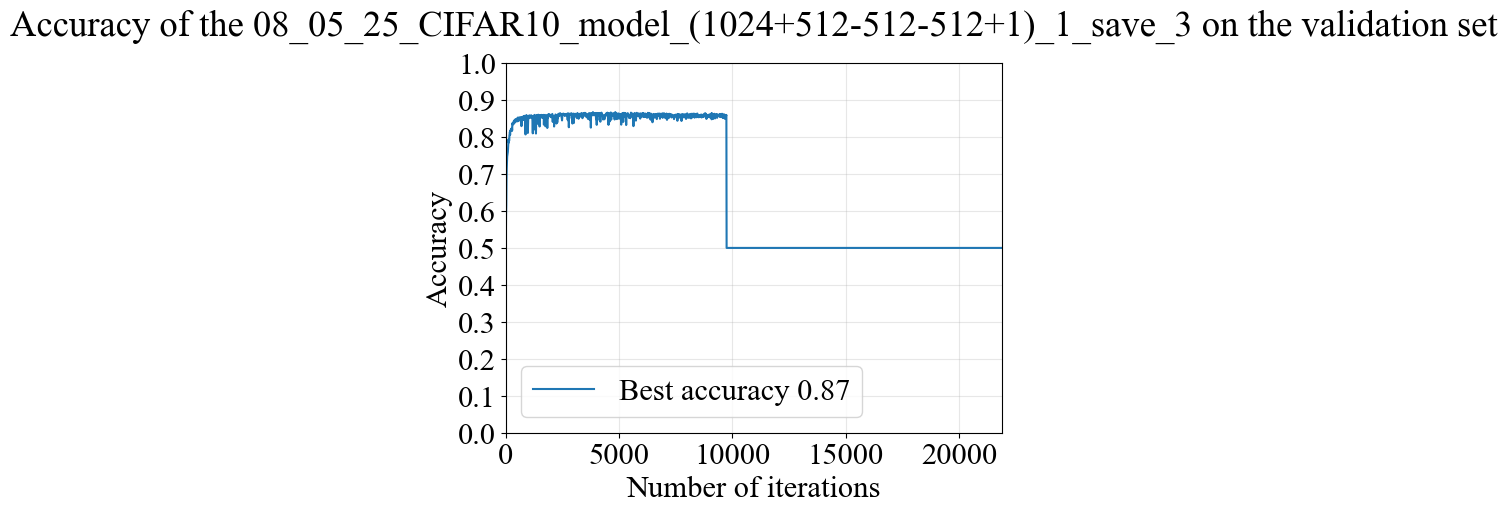

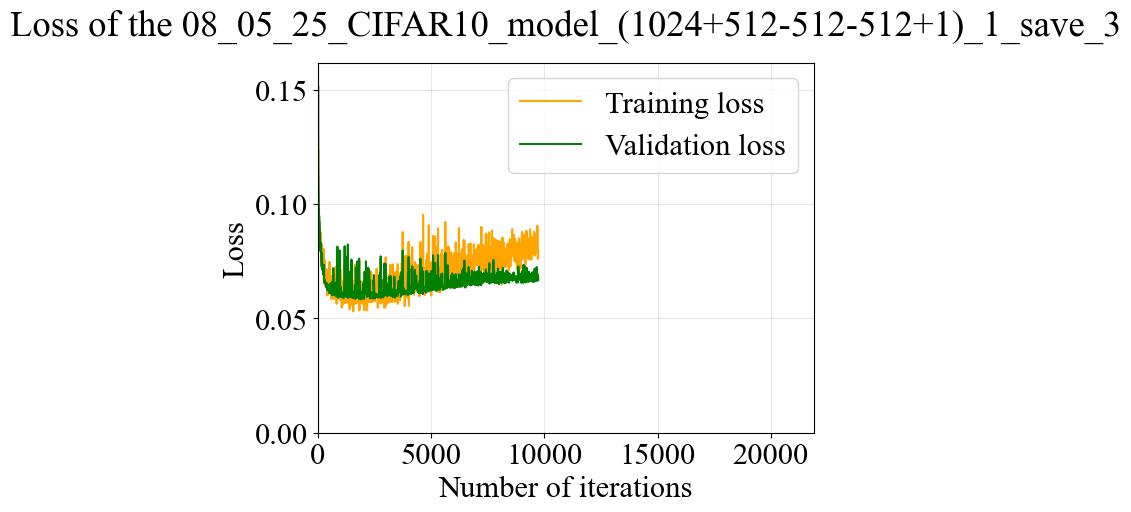

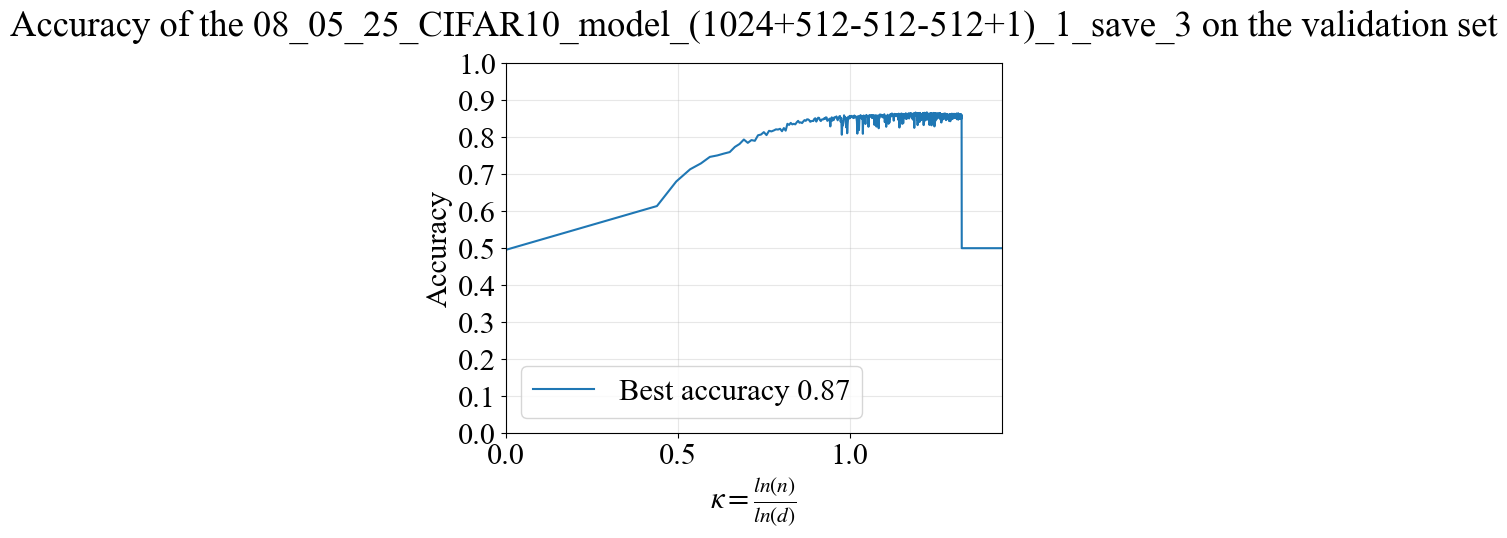

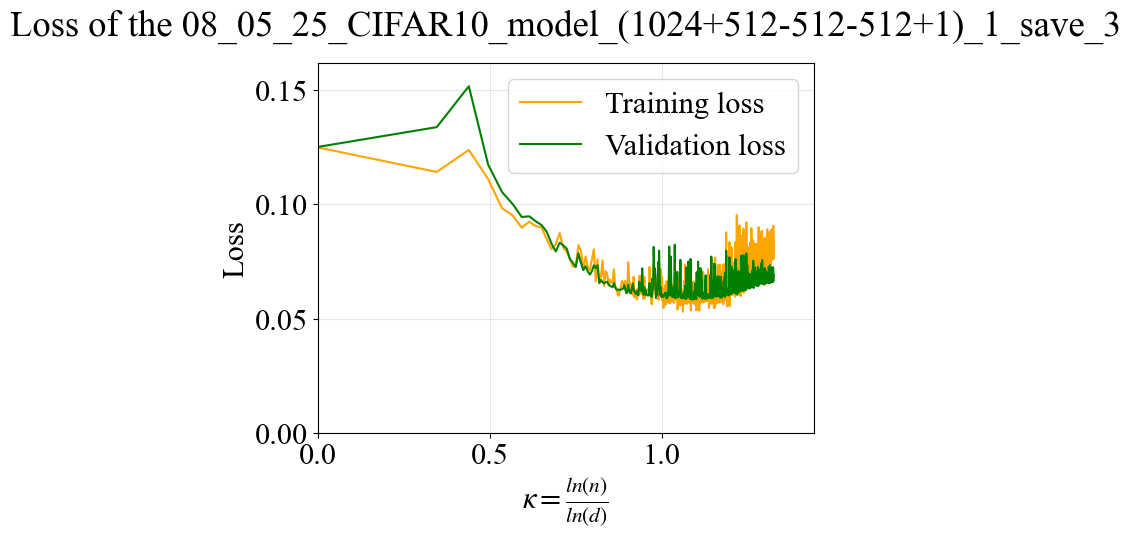

In [15]:
save = True
date = "08_05_25"
if save :
    # Save the model
    model = binary_model_4_layer_extreme_trained
    model_name = date + '_CIFAR10_model_(1024+512-512-512+1)_1_save_3' #
    save_path = "Classifiers/" + date + '/' + model_name + '/'
    os.makedirs(save_path, exist_ok=True)
    torch.save(model , save_path + model_name + ".pt")


    # Save Architecture
    with open(save_path + "architecture.txt", "w", encoding="utf-8") as f:
        f.write(model.architecture + str(model.training_time))

    # Save performances of the model
    os.makedirs(save_path + "figures/", exist_ok=True) 
    # Plot accuracy = f(n)
    plt.plot(np.linspace(0, len(model.accuracy_trajectory)*model.observation_rate, len(model.accuracy_trajectory)), model.accuracy_trajectory, label = "Best accuracy " + str(np.round(np.max(model.accuracy_trajectory), 2)))
    plt.xlim(0, len(model.accuracy_trajectory)*model.observation_rate)
    plt.ylim(0,1)
    plt.yticks(np.linspace(0,1,11))
    plt.xlabel("Number of iterations")  
    plt.ylabel("Accuracy")
    plt.grid(alpha=0.3)
    plt.title("Accuracy of the " + model_name + " on the validation set", pad = 20)
    plt.legend()
    plt.savefig(save_path + "figures/accuracy_of_" + model_name + ".png", bbox_inches='tight')
    plt.savefig(save_path + "figures/accuracy_of_" + model_name + ".svg", bbox_inches='tight')
    data = np.column_stack((np.linspace(0, len(model.accuracy_trajectory)*model.observation_rate, len(model.accuracy_trajectory)), model.accuracy_trajectory)) 
    np.savetxt(save_path +"figures/accuracy_of_" + model_name + ".txt", data, delimiter =",", header="n,accuracy")
    plt.show() 
    
    # Plot training and validation loss = f(n)
    plt.plot(np.linspace(0,len(model.training_loss_trajectory)*model.observation_rate, len(model.training_loss_trajectory)), model.training_loss_trajectory, label = "Training loss", color = "orange")
    plt.plot(np.linspace(0,len(model.validation_loss_trajectory)*model.observation_rate, len(model.validation_loss_trajectory)), model.validation_loss_trajectory, label="Validation loss", color = "green")
    plt.xlim(0, len(model.training_loss_trajectory)*model.observation_rate)
    plt.ylim(0, np.max([np.nan_to_num(model.training_loss_trajectory,nan=0), np.nan_to_num(model.validation_loss_trajectory, nan=0)])+0.01)
    plt.xlabel("Number of iterations")  
    plt.ylabel("Loss")
    plt.grid(alpha=0.3)
    plt.title("Loss of the " + model_name, pad = 20)
    plt.legend()
    plt.savefig(save_path + "figures/loss_of_" + model_name + ".png", bbox_inches='tight')
    plt.savefig(save_path + "figures/loss_of_" + model_name + ".svg", bbox_inches='tight')
    data = np.column_stack((np.linspace(0,len(model.training_loss_trajectory)*model.observation_rate, len(model.training_loss_trajectory)), model.training_loss_trajectory))
    np.savetxt(save_path + "figures/loss_training_" + model_name + ".txt", data, delimiter=",", header="n, training_loss")
    plt.show()
    
    # Plot accuracy = f(kappa)
    kappa = [np.log(n)/np.log(model.input_dimension) for n in np.linspace(1, len(model.accuracy_trajectory)*model.observation_rate+1, len(model.accuracy_trajectory))]
    plt.plot(kappa, model.accuracy_trajectory, label = "Best accuracy " + str(np.round(np.max(model.accuracy_trajectory), 2)))
    plt.xlim(0, np.max(kappa))
    plt.ylim(0,1)
    plt.yticks(np.linspace(0,1,11))
    plt.xlabel(r"$\kappa  = \frac{ln(n)}{ln(d)}$")  
    plt.ylabel("Accuracy")
    plt.grid(alpha=0.3)
    plt.title("Accuracy of the " + model_name + " on the validation set", pad = 20)
    plt.legend()
    plt.savefig(save_path + "figures/kappa_accuracy_of_" + model_name + ".png", bbox_inches='tight')
    plt.savefig(save_path + "figures/kappa_accuracy_of_" + model_name + ".svg", bbox_inches='tight')
    data = np.column_stack((kappa, model.accuracy_trajectory))
    np.savetxt(save_path + "figures/kappa_accuracy_" + model_name + ".txt", data, delimiter=",", header="kappa, accuracy")
    plt.show()
    
    # Plot training and validation loss
    kappa = [np.log(n)/np.log(model.input_dimension) for n in np.linspace(1, len(model.training_loss_trajectory)*model.observation_rate, len(model.training_loss_trajectory))]
    plt.plot(kappa, model.training_loss_trajectory, label = "Training loss", color = "orange")
    plt.plot(kappa, model.validation_loss_trajectory, label = "Validation loss", color = "green")
    plt.xlim(0, np.max(kappa))
    plt.ylim(0, np.max([np.nan_to_num(model.training_loss_trajectory,nan=0), np.nan_to_num(model.validation_loss_trajectory, nan=0)])+0.01)
    plt.xlabel(r"$\kappa  = \frac{ln(n)}{ln(d)}$")  
    plt.ylabel("Loss")
    plt.grid(alpha=0.3)
    plt.title("Loss of the " + model_name, pad = 20)
    plt.legend()
    plt.savefig(save_path + "figures/kappa_loss_of_" + model_name + ".png", bbox_inches='tight')
    plt.savefig(save_path + "figures/kappa_loss_of_" + model_name + ".svg", bbox_inches='tight')
    data_training = np.column_stack((kappa, model.training_loss_trajectory))
    np.savetxt(save_path + "figures/kappa_loss_training_" + model_name + ".txt", data_training, delimiter=",", header="kappa, training_loss")
    data_validation = np.column_stack((kappa, model.validation_loss_trajectory))
    np.savetxt(save_path + "figures/kappa_loss_validation_" + model_name + ".txt", data_validation, delimiter=",", header="kappa, validation_loss")
    plt.show()
    
else:
    print("No save")


In [74]:
os.makedirs('Post-processing/08_05_25/Dataset_3')

2 layers - Training first layer : True - Training second layer : True - kappa = 2.45 - lr = 1e-05 - lr_decay_rate = 100000000.0 - reg1 = 0 - reg2 = 0 - eps_init = 1 - fraction_batch = 0.2 - observation rate = 10 - Train layer 1 = True - Train layer 2 = True - Dropout rate = 0.4
[0.         0.48416665]


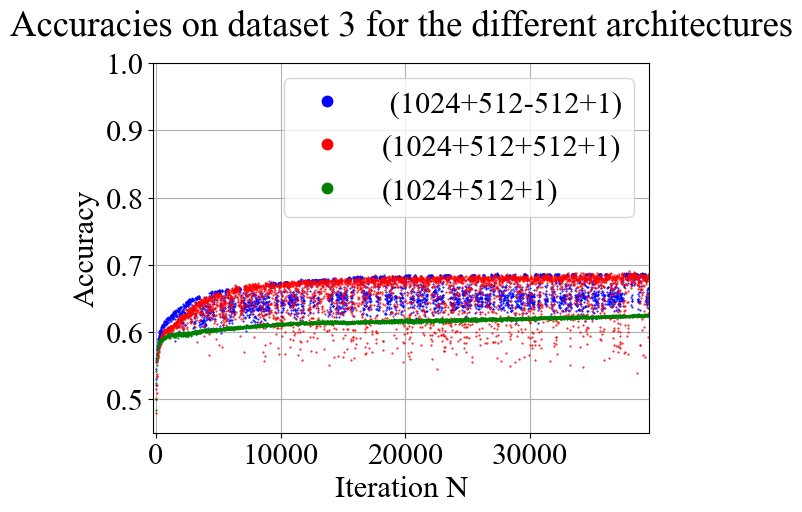

In [10]:
# Import model and plot performances

date = '07_05_25'
model_name = "CIFAR10_model_(1024+512+1)_save_3"
curve_datas = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name + '/figures/accuracy_of_' + model_name +'.txt', delimiter=",", skiprows=1)
assessed_model = torch.load('Classifiers/' + date + '/' + date + '_' +  model_name + '/' + model_name + ".pt", weights_only=False)
save_path = 'Post-processing/08_05_25/Dataset_3/'
# Details of the model
print(assessed_model.architecture)

# Plot the performances
model_name_1 = "CIFAR10_model_(1024+512+1)_3"
model_name_2 = "CIFAR10_model_(1024+512+512+1)_3"
model_name_3 = "CIFAR10_model_(1024+512-512+1)_3"

curve_datas_model_1 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_1 + '/figures/accuracy_of_' + model_name_1 +'.txt', delimiter=",", skiprows=1)
curve_datas_model_2 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_2 + '/figures/accuracy_of_' + date + '_' + model_name_2 +'.txt', delimiter=",", skiprows=1)
curve_datas_model_3 = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_name_3 + '/figures/accuracy_of_' + model_name_3 +'.txt', delimiter=",", skiprows=1)

print(curve_datas_model_1[0])
plt.plot(curve_datas_model_3[:, 0], curve_datas_model_3[:, 1], '.', markersize = '1', color = 'blue', label = ' (1024+512-512+1)')
plt.plot(curve_datas_model_2[:, 0], curve_datas_model_2[:, 1], '.', markersize = '1', color = 'red', label = '(1024+512+512+1)')
plt.plot(curve_datas_model_1[:, 0], curve_datas_model_1[:, 1], '.', markersize = '1', color = 'green', label = '(1024+512+1)')
plt.xlim(-200,np.min([np.max(curve_datas_model_1[:, 0]), np.max(curve_datas_model_2[:, 0]), np.max(curve_datas_model_3[:, 0])]))
plt.ylim(0.45,1)
plt.grid()
plt.xlabel('Iteration N')
plt.ylabel('Accuracy')
plt.title('Accuracies on dataset 3 for the different architectures', pad = 20)
legend = plt.legend()
for handle in legend.legend_handles:
    handle.set_markersize(15)
plt.savefig(save_path + "Zoomed_Comparison_accuracy_dataset_3.png", bbox_inches='tight')
plt.savefig(save_path + "Zoomed_Comparison_accuracy_dataset_3.svg", bbox_inches='tight')
plt.show()
# Plots of performances
# accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".png")
# plt.imshow(accuracy)
# kappa_accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_accuracy_of_" + model_name + ".png")
# plt.imshow(kappa_accuracy)
# loss = mpimg.imread("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".png")
# plt.imshow(loss)
# kappa_loss = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".png")
# plt.imshow(kappa_loss)
# plt.show()

# Import datas
# accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_accuracy_" + model_name + ".txt", delimiter=",", skiprows=1)
# kappa_loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)
